In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Importing Essential Libraries
!pip install tqdm
!pip install imbalanced-learn

In [ ]:
#import essential libraries
import os
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Install the Kaggle package using pip
!pip install kaggle

# Download and prepare Dataset

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from google.colab import files

# Dataset name
dataset_name = 'kmader/skin-cancer-mnist-ham10000'

# Directory to download the dataset
download_dir = '/content/Skin_Cancer/'

# Check if the dataset directory already exists
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Check if the dataset files already exist
files_in_download_dir = os.listdir(download_dir)

# Check if dataset files are already downloaded
if not any(dataset_name in file for file in files_in_download_dir):
    # Upload the Kaggle API token file
    uploaded = files.upload()

    # Move the uploaded file to the correct location
    for fn in uploaded.keys():
        os.rename(fn, '/root/.kaggle/kaggle.json')

    # Set permissions for the Kaggle API token file
    os.chmod('/root/.kaggle/kaggle.json', 600)

    # Create Kaggle API instance
    api = KaggleApi()
    api.authenticate()  # Make sure you to configure your Kaggle API token

    # Download the dataset
    api.dataset_download_files(dataset_name, path=download_dir, unzip=True)

    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists. Skipping download.")

# List files in the downloaded directory
files_list = os.listdir(download_dir)
print("\nFiles in the downloaded directory:")
print(files_list)


Saving kaggle.json to kaggle.json
Dataset downloaded successfully!

Files in the downloaded directory:
['ham10000_images_part_1', 'ham10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv']


In [ ]:
!ls /content/Skin_Cancer

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [ ]:
# Load our custom metadata.csv file "binary classification"
metadata_path = '/content/HAM10000_metadata.csv'
custom_metadata = pd.read_csv(metadata_path)
custom_metadata

,lesion_id,image_id,dx,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Normal,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Normal,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Normal,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Normal,80.0,male,face


In [ ]:
# rename 'dx' column to 'diagnosis'
custom_metadata.rename(columns={'dx': 'diagnosis'}, inplace=True)
custom_metadata

,lesion_id,image_id,diagnosis,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Normal,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Normal,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Normal,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Normal,80.0,male,face


In [ ]:
# Count the occurrences of unique values in the 'dx' column of the custom_metadata DataFrame
custom_metadata['diagnosis'].value_counts()

Normal    8388
Cancer    1627
Name: diagnosis, dtype: int64

In [ ]:
# saving updated metadata.csv
custom_metadata.to_csv("/content/HAM10000_metadata.csv")

In [ ]:
# Organizing Normal images in seprate directory
def organize_normal_images(metadata_path, base_dir, target_diagnosis, image_dirs):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(metadata_path)

    # Check if the target diagnosis directory already exists
    label_dir = os.path.join(base_dir, str(target_diagnosis))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        print(f"Directory for {target_diagnosis} created.")
    else:
        print(f"Directory for {target_diagnosis} already exists.")

    # Iterate through rows and organize images only for the target diagnosis
    for index, row in df.iterrows():
        lesion_id = row['lesion_id']
        image_id = row['image_id']
        diagnosis = row['diagnosis']

        # Check if the current image has the target diagnosis
        if diagnosis == target_diagnosis:
            image_source_path = None

            # Check each image directory for the image
            for image_dir in image_dirs:
                current_image_path = os.path.join(image_dir, f"{image_id}.jpg")

                # Check if the image exists in the current directory
                if os.path.exists(current_image_path):
                    image_source_path = current_image_path
                    break

            # Check if the image exists in any of the source directories
            if image_source_path is not None:
                image_dest_path = os.path.join(label_dir, f"{image_id}.jpg")

                # Check if the image already exists in the destination directory
                if not os.path.exists(image_dest_path):
                    # Copy or move the image to the corresponding label directory
                    # You can use shutil.copy or shutil.move for this
                    # For simplicity, I'll use shutil.copy as an example
                    shutil.copy(image_source_path, image_dest_path)
                    print(f"Image {image_id} copied to {target_diagnosis} directory.")
                else:
                    print(f"Image {image_id} already exists in {target_diagnosis} directory.")
            else:
                print(f"Image {image_id} not found in any source directory.")

    print(f"Directories and images for {target_diagnosis} organized successfully.")

# Example usage:
metadata_path = "/content/HAM10000_metadata.csv"
base_directory = "/content/gdrive/MyDrive/Images"
diagnosis_to_organize = "Normal"
image_directories = ["/content/Skin_Cancer/HAM10000_images_part_1", "/content/Skin_Cancer/HAM10000_images_part_2"]

organize_normal_images(metadata_path, base_directory, diagnosis_to_organize, image_directories)

Streaming output truncated to the last 5000 lines.
Image ISIC_0025770 copied to Normal directory.
Image ISIC_0032224 copied to Normal directory.
Image ISIC_0031264 copied to Normal directory.
Image ISIC_0026639 copied to Normal directory.
Image ISIC_0031979 copied to Normal directory.
Image ISIC_0031680 copied to Normal directory.
Image ISIC_0026917 copied to Normal directory.
Image ISIC_0025207 copied to Normal directory.
Image ISIC_0029738 copied to Normal directory.
Image ISIC_0031627 copied to Normal directory.
Image ISIC_0027804 copied to Normal directory.
Image ISIC_0031828 copied to Normal directory.
Image ISIC_0025395 copied to Normal directory.
Image ISIC_0030304 copied to Normal directory.
Image ISIC_0030982 copied to Normal directory.
Image ISIC_0025445 copied to Normal directory.
Image ISIC_0024509 copied to Normal directory.
Image ISIC_0031419 copied to Normal directory.
Image ISIC_0031949 copied to Normal directory.
Image ISIC_0028996 copied to Normal directory.
Image ISI

In [ ]:
# Organizing Cancer images in seprate directory
def organize_cancer_images(metadata_path, base_dir, target_diagnosis, image_dirs):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(metadata_path)

    # Check if the target diagnosis directory already exists
    label_dir = os.path.join(base_dir, str(target_diagnosis))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        print(f"Directory for {target_diagnosis} created.")
    else:
        print(f"Directory for {target_diagnosis} already exists.")

    # Iterate through rows and organize images only for the target diagnosis
    for index, row in df.iterrows():
        lesion_id = row['lesion_id']
        image_id = row['image_id']
        diagnosis = row['diagnosis']

        # Check if the current image has the target diagnosis
        if diagnosis == target_diagnosis:
            image_source_path = None

            # Check each image directory for the image
            for image_dir in image_dirs:
                current_image_path = os.path.join(image_dir, f"{image_id}.jpg")

                # Check if the image exists in the current directory
                if os.path.exists(current_image_path):
                    image_source_path = current_image_path
                    break

            # Check if the image exists in any of the source directories
            if image_source_path is not None:
                image_dest_path = os.path.join(label_dir, f"{image_id}.jpg")

                # Check if the image already exists in the destination directory
                if not os.path.exists(image_dest_path):
                    # Copy or move the image to the corresponding label directory
                    # You can use shutil.copy or shutil.move for this
                    # For simplicity, I'll use shutil.copy as an example
                    shutil.copy(image_source_path, image_dest_path)
                    print(f"Image {image_id} copied to {target_diagnosis} directory.")
                else:
                    print(f"Image {image_id} already exists in {target_diagnosis} directory.")
            else:
                print(f"Image {image_id} not found in any source directory.")

    print(f"Directories and images for {target_diagnosis} organized successfully.")

# Example usage:
metadata_path = "/content/HAM10000_metadata.csv"
base_directory = "/content/gdrive/MyDrive/Images"
diagnosis_to_organize = "Cancer"
image_directories = ["/content/Skin_Cancer/HAM10000_images_part_1", "/content/Skin_Cancer/HAM10000_images_part_2"]

organize_cancer_images(metadata_path, base_directory, diagnosis_to_organize, image_directories)

Directory for Cancer created.
Image ISIC_0025964 copied to Cancer directory.
Image ISIC_0030623 copied to Cancer directory.
Image ISIC_0027190 copied to Cancer directory.
Image ISIC_0031023 copied to Cancer directory.
Image ISIC_0028086 copied to Cancer directory.
Image ISIC_0031177 copied to Cancer directory.
Image ISIC_0026993 copied to Cancer directory.
Image ISIC_0026120 copied to Cancer directory.
Image ISIC_0028412 copied to Cancer directory.
Image ISIC_0030417 copied to Cancer directory.
Image ISIC_0026531 copied to Cancer directory.
Image ISIC_0032396 copied to Cancer directory.
Image ISIC_0030443 copied to Cancer directory.
Image ISIC_0031499 copied to Cancer directory.
Image ISIC_0025450 copied to Cancer directory.
Image ISIC_0024586 copied to Cancer directory.
Image ISIC_0025451 copied to Cancer directory.
Image ISIC_0032248 copied to Cancer directory.
Image ISIC_0028445 copied to Cancer directory.
Image ISIC_0027076 copied to Cancer directory.
Image ISIC_0029512 copied to C

# Augmenting and visualization images in cancer directory

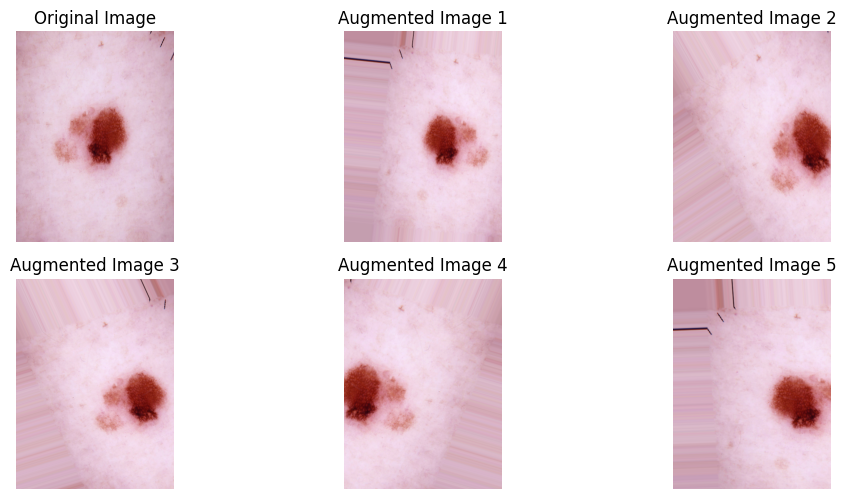

In [ ]:
# Augmenting and visualizing an image from cancer directory
def augment_and_visualize_single_image(image_path, target_size=(600, 450), num_augmented_images=5):
    # Load the single image
    img = image.load_img(image_path, target_size=target_size)

    # Convert the image to a numpy array
    x = image.img_to_array(img)

    # Reshape the image to (1, height, width, channels) as required by the flow() method
    x = np.expand_dims(x, axis=0)

    # Create an instance of the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented images and visualize them
    plt.figure(figsize=(10, 15))

    # Display the original image
    plt.subplot(num_augmented_images + 1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Display augmented images
    for i, batch in enumerate(datagen.flow(x, batch_size=1), start=2):
        plt.subplot(num_augmented_images + 1, 3, i)
        plt.imshow(image.array_to_img(batch[0]))
        plt.title(f'Augmented Image {i-1}')
        plt.axis('off')
        if i > (num_augmented_images):  # Display the specified number of augmented images
            break

    plt.tight_layout()
    plt.show()

# Path to the directory containing the single image
image_dir = "/content/gdrive/MyDrive/Images/Cancer"

# Specify the image file name
image_file = "ISIC_0024313.jpg"

# Full path to the image
image_path = os.path.join(image_dir, image_file)

# Call the function to augment and visualize a single image
augment_and_visualize_single_image(image_path)

In [ ]:
#Augmenting images in cancer directory
def augment_images(original_image_dir, augmented_image_dir, target_size=(600, 450), num_augmented_images=4):

    # Create the output directory if it doesn't exist
    if not os.path.exists(augmented_image_dir):
        os.makedirs(augmented_image_dir)

    # Create an instance of the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Get the list of image files in the original directory
    image_files = [f for f in os.listdir(original_image_dir) if f.endswith('.jpg')]

    # Iterate through each image file and apply augmentation
    for img_file in image_files:
        # Get the image ID from the file name
        image_id = os.path.splitext(img_file)[0]

        print(f"Augmenting images for: {image_id}")

        # Load the image
        img_path = os.path.join(original_image_dir, img_file)
        img = image.load_img(img_path, target_size=target_size)

        # Convert the image to a numpy array
        x = image.img_to_array(img)

        # Reshape the image to (1, height, width, channels) as required by the flow() method
        x = np.expand_dims(x, axis=0)

        # Generate augmented images and save them to the output directory
        for i in range(1, num_augmented_images + 1):
            batch = next(datagen.flow(x, batch_size=1))
            augmented_image_path = os.path.join(augmented_image_dir, f'{image_id}_aug_{i}.jpg')
            image.save_img(augmented_image_path, batch[0])
            print(f"Saved augmented image {i}/{num_augmented_images}: {augmented_image_path}")

        print(f"Augmentation complete for: {image_id}")
        print(f"Original Image: {image_id}.jpg, Augmented Images: {num_augmented_images}")

# Example usage:
original_image_directory = "/content/gdrive/MyDrive/Images/Cancer"
augmented_image_directory = "/content/gdrive/MyDrive/Images/Aug_Cancer_1627_4"
augment_images(original_image_directory, augmented_image_directory, target_size=(600, 450), num_augmented_images=4)

Streaming output truncated to the last 5000 lines.
Augmentation complete for: ISIC_0025391
Original Image: ISIC_0025391.jpg, Augmented Images: 4
Augmenting images for: ISIC_0025413
Saved augmented image 1/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0025413_aug_1.jpg
Saved augmented image 2/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0025413_aug_2.jpg
Saved augmented image 3/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0025413_aug_3.jpg
Saved augmented image 4/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0025413_aug_4.jpg
Augmentation complete for: ISIC_0025413
Original Image: ISIC_0025413.jpg, Augmented Images: 4
Augmenting images for: ISIC_0032192
Saved augmented image 1/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0032192_aug_1.jpg
Saved augmented image 2/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0032192_aug_2.jpg
Saved augmented image 3/4: /content/gdrive/MyDrive/Images/Aug_Cancer_1627_4/ISIC_0032192_aug_3.

In [ ]:
#Count the number of files in Aug_Cancer directory
import os

# Define the directory path
directory_path_part_1 = '/content/gdrive/MyDrive/Images/Aug_Cancer_1627_4'

# Function to count files in a directory
def count_files_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Count the number of files
        num_files = len(files)

        return num_files
    except FileNotFoundError:
        return 0  # Return 0 if the directory is not found

# Count files in each directory
num_files_part_1 = count_files_in_directory(directory_path_part_1)

# Print the results
print(f'Number of files in Aug_Cancer: {num_files_part_1}')

Number of files in Aug_Cancer: 6508


In [ ]:
# Combined metadata.csv (Normal + Cancer + Aug_Cancer_1627_4)

import os
import pandas as pd

def create_augmented_metadata(original_metadata_path, augmented_image_dir, output_metadata_path):
    # Load the original metadata
    original_metadata = pd.read_csv(original_metadata_path)

    # Get the list of image files in the augmented directory
    augmented_image_files = [f for f in os.listdir(augmented_image_dir) if f.endswith('.jpg')]

    # Create a new DataFrame to store augmented metadata
    augmented_metadata = pd.DataFrame(columns=original_metadata.columns)

    for augmented_image_file in augmented_image_files:
        # Extract information from the augmented image filename
        file_parts = os.path.splitext(augmented_image_file)[0].split('_')
        original_image_id = '_'.join(file_parts[:-2])  # Extract the original image ID
        augmentation_number = int(file_parts[-1])  # Extract the augmentation number

        # Find the corresponding row in the original metadata
        original_row = original_metadata[original_metadata['image_id'] == original_image_id]

        # Check if the original image is present in the original metadata
        if not original_row.empty:
            # Create a new row for the augmented image
            augmented_row = original_row.copy()
            augmented_row['image_id'] = f"{original_image_id}_aug_{augmentation_number}"
            augmented_row['file_path'] = os.path.join(augmented_image_dir, augmented_image_file)

            # Append the augmented row to the new metadata
            augmented_metadata = pd.concat([augmented_metadata, augmented_row], ignore_index=True)

    # Concatenate the original and augmented metadata
    combined_metadata = pd.concat([original_metadata, augmented_metadata], ignore_index=True)

    # Save the combined metadata to a new CSV file
    combined_metadata.to_csv(output_metadata_path, index=False)
    print(f"Combined metadata saved to {output_metadata_path}")

# Example usage:
original_metadata_path = "/content/HAM10000_metadata.csv"
augmented_cancer_image_directory = "/content/gdrive/MyDrive/Images/Aug_Cancer_1627_4"
output_metadata_path = "/content/gdrive/MyDrive/Images/HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv"

create_augmented_metadata(original_metadata_path, augmented_cancer_image_directory, output_metadata_path)

Combined metadata saved to /content/gdrive/MyDrive/Images/HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv


In [ ]:
# Reading HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv (Normal + Cancer + Aug_Cancer)
df = pd.read_csv('/content/gdrive/MyDrive/Images/HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv')
df

,Unnamed: 0,lesion_id,image_id,diagnosis,age,sex,localization,file_path
0,0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,NaN
1,1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp,NaN
2,2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp,NaN
3,3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp,NaN
4,4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear,NaN
...,...,...,...,...,...,...,...,...
16518,8834,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...
16519,10014,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...
16520,10014,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...
16521,10014,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...


In [ ]:
# dropping "unnamed: 0" column from dataframe
df.drop(columns=['Unnamed: 0', 'file_path'], inplace=True)
df

,lesion_id,image_id,diagnosis,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back


In [ ]:
# Count the occurrences of each unique value in the 'diagnosis' column of the DataFrame
df['diagnosis'].value_counts()

Normal    8388
Cancer    8135
Name: diagnosis, dtype: int64

# Feature Extraction (Normal + Cancer + Aug_Cancer_1627_4)

In [ ]:
# Gray_scale image of 8*8 size
from skimage import io, color, transform
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def process_image_gray(image_id, image_path, lesion_id):
    # Read and resize the image to 8x8 pixels in grayscale
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)
    image_resized = transform.resize(image_gray, (8, 8), anti_aliasing=True)

    # Flatten the pixel values and create a DataFrame row
    features_row = pd.DataFrame(np.reshape(image_resized, (1, -1)))

    # Normalize pixel values to the range [0, 1]
    normalized_features = (features_row - features_row.min().min()) / (features_row.max().max() - features_row.min().min())

    # Include 'image_id' and 'lesion_id' in the features DataFrame
    normalized_features['image_id'] = image_id
    normalized_features['lesion_id'] = lesion_id

    return normalized_features

def extract_features_and_save(image_dir_normal, image_dir_cancer, image_dir_aug_cancer, custom_metadata_path, features_csv_path):

    # Load custom metadata
    custom_metadata = pd.read_csv(custom_metadata_path)

    # Initialize an empty DataFrame to store features
    features_df = pd.DataFrame()

    # Check if the features CSV file already exists
    if os.path.exists(features_csv_path):
        print("Features CSV file already exists. Skipping feature extraction.")
        return
    else:
        # Use tqdm for a progress bar with green color
        with tqdm(total=len(custom_metadata), bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]", colour='green') as pbar:
            # Loop through each row in the custom metadata
            for index, row in custom_metadata.iterrows():
                lesion_id = row['lesion_id']
                image_id = row['image_id']

                # Construct the full path to the image file
                image_path = None
                for directory in [image_dir_normal, image_dir_cancer, image_dir_aug_cancer]:
                    if os.path.exists(os.path.join(directory, f"{image_id}.jpg")):
                        image_path = os.path.join(directory, f"{image_id}.jpg")
                        break

                if image_path is None:
                    print(f"Image not found for {image_id}. Skipping.")
                    pbar.update(1)  # Update progress bar
                    continue

                result = process_image_gray(image_id, image_path, lesion_id)
                features_df = pd.concat([features_df, result], ignore_index=True)
                pbar.update(1)  # Update progress bar

            # Save the features DataFrame to a CSV file
            features_df.to_csv(features_csv_path, index=False)
            print(f"Grayscale Features saved to {features_csv_path}")

# Example usage:
image_dir_normal = '/content/gdrive/MyDrive/Images/Normal'
image_dir_cancer = '/content/gdrive/MyDrive/Images/Cancer'
image_dir_aug_cancer_1627_4 = '/content/gdrive/MyDrive/Images/Aug_Cancer_1627_4'
custom_metadata_path = '/content/gdrive/MyDrive/Images/HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv'
features_csv_path = '/content/gdrive/MyDrive/Images/8_8_Grayscale_features_normalized_stage1.csv'

extract_features_and_save(image_dir_normal, image_dir_cancer, image_dir_aug_cancer_1627_4, custom_metadata_path, features_csv_path)

Features CSV file already exists. Skipping feature extraction.


In [ ]:
# RGB image of 8*8 size
from skimage import io, transform
import numpy as np
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_image(image_id, image_path, lesion_id, image_dir_aug_cancer):
    # Read and resize the image to 8x8 pixels
    image = io.imread(image_path)
    image_resized = transform.resize(image, (8, 8), anti_aliasing=True)

    # Flatten the pixel values for each channel separately
    flattened_features = image_resized.reshape(-1, 3)

    # Normalize pixel values to the range [0, 1]
    normalized_features = (flattened_features - flattened_features.min(axis=0)) / (flattened_features.max(axis=0) - flattened_features.min(axis=0))

    # Include 'image_id' and 'lesion_id' in the features DataFrame
    normalized_features_df = pd.DataFrame(normalized_features, columns=['R', 'G', 'B'])
    normalized_features_df['image_id'] = image_id
    normalized_features_df['lesion_id'] = lesion_id

    return normalized_features_df

def extract_rgb_features_and_save(image_dir_normal, image_dir_cancer, image_dir_aug_cancer, custom_metadata_path, features_csv_path):
    # Load custom metadata
    custom_metadata = pd.read_csv(custom_metadata_path)

    # Check if the features CSV file already exists
    if os.path.exists(features_csv_path):
        print("Features CSV file already exists. Skipping feature extraction.")
        return

    # Use tqdm for a progress bar
    with tqdm(total=len(custom_metadata)) as pbar:
        # Define the processing function for each image
        def process_image_wrapper(row):
            image_id = row['image_id']
            lesion_id = row['lesion_id']

            # Construct the full path to the image file
            if os.path.exists(os.path.join(image_dir_normal, f"{image_id}.jpg")):
                image_path = os.path.join(image_dir_normal, f"{image_id}.jpg")
            elif os.path.exists(os.path.join(image_dir_cancer, f"{image_id}.jpg")):
                image_path = os.path.join(image_dir_cancer, f"{image_id}.jpg")
            elif os.path.exists(os.path.join(image_dir_aug_cancer, f"{image_id}.jpg")):
                image_path = os.path.join(image_dir_aug_cancer, f"{image_id}.jpg")
            else:
                print(f"Image not found for {image_id}. Skipping.")
                pbar.update(1)  # Update progress bar
                return pd.DataFrame()

            return process_image(image_id, image_path, lesion_id, image_dir_aug_cancer)

        # Use ThreadPoolExecutor for parallel processing
        with ThreadPoolExecutor() as executor:
            # Submit tasks to the executor
            futures = [executor.submit(process_image_wrapper, row) for _, row in custom_metadata.iterrows()]

            # Process completed tasks
            for future in futures:
                result = future.result()
                if not result.empty:
                    pbar.update(1)  # Update progress bar

    # Concatenate the results into a single DataFrame
    features_df = pd.concat([future.result() for future in futures if not future.result().empty], ignore_index=True)

    # Save the features DataFrame to a CSV file
    features_df.to_csv(features_csv_path, index=False)
    print(f"Features saved to {features_csv_path}")

# Example usage:
image_dir_normal = '/content/gdrive/MyDrive/Images/Normal'
image_dir_cancer = '/content/gdrive/MyDrive/Images/Cancer'
image_dir_aug_cancer = '/content/gdrive/MyDrive/Images/Aug_Cancer_1627_4'
custom_metadata_path = '/content/gdrive/MyDrive/Images/HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv'
features_csv_path = '/content/gdrive/MyDrive/Images/8_8_RGB_features_normalized_stage1.csv'

extract_rgb_features_and_save(image_dir_normal, image_dir_cancer, image_dir_aug_cancer, custom_metadata_path, features_csv_path)

Features CSV file already exists. Skipping feature extraction.


# Reading The Features and Training Models "Grayscale"

In [ ]:
# Load the features CSV file of 8*8 gryscale
features_path = '/content/gdrive/MyDrive/Images/8_8_Grayscale_features_normalized_stage1.csv'
features_df = pd.read_csv(features_path)
features_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,image_id,lesion_id
0,0.362525,0.552011,0.700388,0.562363,0.500827,0.462800,0.242420,0.212483,0.380833,0.695641,...,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496,ISIC_0027419,HAM_0000118
1,0.213094,0.562749,0.738689,0.858989,0.812301,0.696959,0.633339,0.257653,0.468670,0.722821,...,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000,ISIC_0025030,HAM_0000118
2,0.314948,0.349545,0.567544,0.426858,0.163901,0.298139,0.339202,0.000000,0.410216,0.538625,...,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510,ISIC_0026769,HAM_0002730
3,0.384494,0.701408,0.793985,0.801822,0.769866,0.753710,0.680544,0.310063,0.596467,0.781057,...,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000,ISIC_0025661,HAM_0002730
4,0.418254,0.590735,0.649672,0.621683,0.715350,0.989346,0.993962,0.705932,0.408010,0.206432,...,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081,ISIC_0031633,HAM_0001466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,0.979630,0.968357,0.935843,0.901567,0.856259,0.829929,0.825384,0.820348,0.992661,0.962002,...,0.868012,0.872089,0.903802,0.891718,0.827954,0.771250,0.817383,0.843626,ISIC_0033232_aug_4,HAM_0002552
16519,0.915209,0.871891,0.866597,1.000000,0.914886,0.843744,0.776578,0.723859,0.887362,0.913548,...,0.764182,0.842362,0.854236,0.879241,0.891714,0.903771,0.907870,0.599124,ISIC_0032258_aug_1,HAM_0003521
16520,0.919358,0.969192,0.980032,0.952996,0.905763,0.846964,0.921378,0.880588,0.883213,1.000000,...,0.934285,0.837766,0.785059,0.751796,0.731463,0.704457,0.669834,0.648398,ISIC_0032258_aug_2,HAM_0003521
16521,0.892634,0.922071,0.943009,0.980933,0.993034,0.849961,0.809522,0.754073,0.773669,0.931557,...,0.880427,1.000000,0.978595,0.950738,0.689813,0.000000,0.657893,0.768858,ISIC_0032258_aug_3,HAM_0003521


In [ ]:
# Merge metadata with features based on common columns, e.g., 'image_id', 'lesion_id'.
merged_data = pd.merge(df, features_df, on=['lesion_id', 'image_id'])
merged_data

,lesion_id,image_id,diagnosis,age,sex,localization,0,1,2,3,...,54,55,56,57,58,59,60,61,62,63
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.362525,0.552011,0.700388,0.562363,...,0.303623,0.177692,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp,0.213094,0.562749,0.738689,0.858989,...,0.672509,0.442991,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp,0.314948,0.349545,0.567544,0.426858,...,0.580511,0.403992,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp,0.384494,0.701408,0.793985,0.801822,...,0.690972,0.338256,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear,0.418254,0.590735,0.649672,0.621683,...,0.736811,0.845363,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity,0.979630,0.968357,0.935843,0.901567,...,0.672288,0.808286,0.868012,0.872089,0.903802,0.891718,0.827954,0.771250,0.817383,0.843626
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back,0.915209,0.871891,0.866597,1.000000,...,0.869972,0.596615,0.764182,0.842362,0.854236,0.879241,0.891714,0.903771,0.907870,0.599124
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back,0.919358,0.969192,0.980032,0.952996,...,0.706513,0.760141,0.934285,0.837766,0.785059,0.751796,0.731463,0.704457,0.669834,0.648398
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back,0.892634,0.922071,0.943009,0.980933,...,0.692010,0.776027,0.880427,1.000000,0.978595,0.950738,0.689813,0.000000,0.657893,0.768858


In [ ]:
# dropping age, sex and localization column
merged_data = merged_data.drop(['age', 'sex', 'localization'], axis=1)
merged_data

,lesion_id,image_id,diagnosis,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,HAM_0000118,ISIC_0027419,Normal,0.362525,0.552011,0.700388,0.562363,0.500827,0.462800,0.242420,...,0.303623,0.177692,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496
1,HAM_0000118,ISIC_0025030,Normal,0.213094,0.562749,0.738689,0.858989,0.812301,0.696959,0.633339,...,0.672509,0.442991,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000
2,HAM_0002730,ISIC_0026769,Normal,0.314948,0.349545,0.567544,0.426858,0.163901,0.298139,0.339202,...,0.580511,0.403992,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510
3,HAM_0002730,ISIC_0025661,Normal,0.384494,0.701408,0.793985,0.801822,0.769866,0.753710,0.680544,...,0.690972,0.338256,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000
4,HAM_0001466,ISIC_0031633,Normal,0.418254,0.590735,0.649672,0.621683,0.715350,0.989346,0.993962,...,0.736811,0.845363,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,0.979630,0.968357,0.935843,0.901567,0.856259,0.829929,0.825384,...,0.672288,0.808286,0.868012,0.872089,0.903802,0.891718,0.827954,0.771250,0.817383,0.843626
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,0.915209,0.871891,0.866597,1.000000,0.914886,0.843744,0.776578,...,0.869972,0.596615,0.764182,0.842362,0.854236,0.879241,0.891714,0.903771,0.907870,0.599124
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,0.919358,0.969192,0.980032,0.952996,0.905763,0.846964,0.921378,...,0.706513,0.760141,0.934285,0.837766,0.785059,0.751796,0.731463,0.704457,0.669834,0.648398
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,0.892634,0.922071,0.943009,0.980933,0.993034,0.849961,0.809522,...,0.692010,0.776027,0.880427,1.000000,0.978595,0.950738,0.689813,0.000000,0.657893,0.768858


In [ ]:
# value counts of diagnosis column
merged_data['diagnosis'].value_counts()

Normal    8388
Cancer    8135
Name: diagnosis, dtype: int64

In [ ]:
# Convert the column to string type
merged_data['diagnosis'] = merged_data['diagnosis'].astype(str)

In [ ]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'diagnosis' column
merged_data['diagnosis_label'] = label_encoder.fit_transform(merged_data['diagnosis'])

# Swap the labels
merged_data['diagnosis_label'] = 1 - merged_data['diagnosis_label']

# Display the updated DataFrame
merged_data[['diagnosis', 'diagnosis_label']]

,diagnosis,diagnosis_label
0,Normal,0
1,Normal,0
2,Normal,0
3,Normal,0
4,Normal,0
...,...,...
16518,Cancer,1
16519,Cancer,1
16520,Cancer,1
16521,Cancer,1


In [ ]:
merged_data

,lesion_id,image_id,diagnosis,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,diagnosis_label
0,HAM_0000118,ISIC_0027419,Normal,0.362525,0.552011,0.700388,0.562363,0.500827,0.462800,0.242420,...,0.177692,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496,0
1,HAM_0000118,ISIC_0025030,Normal,0.213094,0.562749,0.738689,0.858989,0.812301,0.696959,0.633339,...,0.442991,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000,0
2,HAM_0002730,ISIC_0026769,Normal,0.314948,0.349545,0.567544,0.426858,0.163901,0.298139,0.339202,...,0.403992,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510,0
3,HAM_0002730,ISIC_0025661,Normal,0.384494,0.701408,0.793985,0.801822,0.769866,0.753710,0.680544,...,0.338256,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000,0
4,HAM_0001466,ISIC_0031633,Normal,0.418254,0.590735,0.649672,0.621683,0.715350,0.989346,0.993962,...,0.845363,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,0.979630,0.968357,0.935843,0.901567,0.856259,0.829929,0.825384,...,0.808286,0.868012,0.872089,0.903802,0.891718,0.827954,0.771250,0.817383,0.843626,1
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,0.915209,0.871891,0.866597,1.000000,0.914886,0.843744,0.776578,...,0.596615,0.764182,0.842362,0.854236,0.879241,0.891714,0.903771,0.907870,0.599124,1
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,0.919358,0.969192,0.980032,0.952996,0.905763,0.846964,0.921378,...,0.760141,0.934285,0.837766,0.785059,0.751796,0.731463,0.704457,0.669834,0.648398,1
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,0.892634,0.922071,0.943009,0.980933,0.993034,0.849961,0.809522,...,0.776027,0.880427,1.000000,0.978595,0.950738,0.689813,0.000000,0.657893,0.768858,1


In [ ]:
# train_test_split

from sklearn.model_selection import train_test_split

# Shuffle the data
shuffled_data = merged_data.sample(frac=1, random_state=42)

# Split the shuffled data into features (X) and labels (y)
X = shuffled_data.drop(['lesion_id', 'image_id', 'diagnosis', 'diagnosis_label'], axis=1)
y = shuffled_data['diagnosis_label']

# Split the shuffled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Naive Bayes**



Naive Bayes
Accuracy: 0.6907715582450832
Precision: 0.6949148935808137
Recall: 0.6907715582450832
F1 Score: 0.6889566832846032


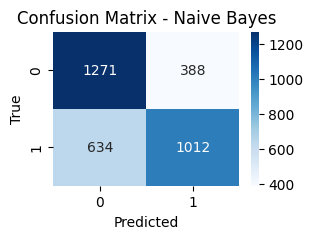

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

# Evaluate Naive Bayes
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(y_test, nb_predictions, average='weighted')
nb_confusion = confusion_matrix(y_test, nb_predictions)

print("\n\nNaive Bayes")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1 Score: {nb_f1}")

# Confusion Matrix
plt.figure(figsize=(3, 2))
sns.heatmap(nb_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**SVM**



SVM
Accuracy: 0.8127080181543116
Precision: 0.8212377118840336
Recall: 0.8127080181543116
F1 Score: 0.8113785356315557


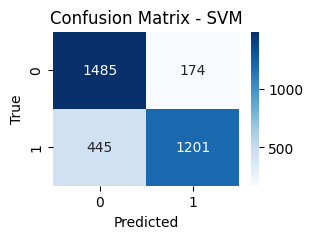

In [ ]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(y_test, svm_predictions, average='weighted')
svm_confusion = confusion_matrix(y_test, svm_predictions)

print("\n\nSVM")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1 Score: {svm_f1}")

# Confusion Matrix
plt.figure(figsize=(3, 2))
sns.heatmap(svm_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Decision Tree**



Decision Tree
Accuracy: 0.6962178517397882
Precision: 0.6962161089835954
Recall: 0.6962178517397882
F1 Score: 0.6962159605299227


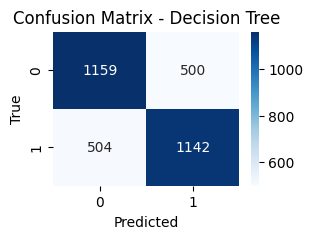

In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluate Decision Tree
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision, dt_recall, dt_f1, _ = precision_recall_fscore_support(y_test, dt_predictions, average='weighted')
dt_confusion = confusion_matrix(y_test, dt_predictions)

print("\n\nDecision Tree")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1 Score: {dt_f1}")

# Confusion Matrix
plt.figure(figsize=(3, 2))
sns.heatmap(dt_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**Random Forest**



Random Forest
Accuracy: 0.8078668683812406
Precision: 0.8097547685109369
Recall: 0.8078668683812406
F1 Score: 0.8075344244885079


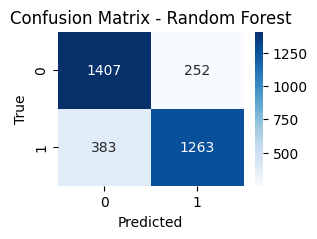

In [ ]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, rf_predictions, average='weighted')
rf_confusion = confusion_matrix(y_test, rf_predictions)

print("\n\nRandom Forest")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")

# Confusion Matrix
plt.figure(figsize=(3, 2))
sns.heatmap(rf_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

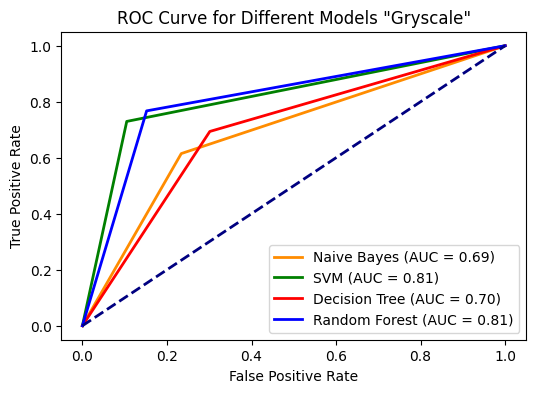

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_predictions)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_predictions)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_predictions)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Naive Bayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models "Gryscale"')
plt.legend(loc="lower right")
plt.show()

# Reading The Features and Training Models "RGB"

## Loading Combined metadata.csv

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Images/HAM10000_metadata_Normal_Cancer_Aug_Cancer_1627_4.csv')
df

,Unnamed: 0,lesion_id,image_id,diagnosis,age,sex,localization,file_path
0,0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,NaN
1,1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp,NaN
2,2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp,NaN
3,3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp,NaN
4,4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear,NaN
...,...,...,...,...,...,...,...,...
16518,8834,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...
16519,10014,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...
16520,10014,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...
16521,10014,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer_1627...


In [ ]:
# dropping "unnamed: 0" column from dataframe
df.drop(columns=['Unnamed: 0', 'file_path'], inplace=True)
df

,lesion_id,image_id,diagnosis,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back


In [ ]:
# Count the occurrences of each unique value in the 'diagnosis' column of the DataFrame
df['diagnosis'].value_counts()

Normal    8388
Cancer    8135
Name: diagnosis, dtype: int64

In [ ]:
# Load your features CSV file
features_path = '/content/gdrive/MyDrive/Images/8_8_RGB_features_normalized_stage1.csv'
features_df1 = pd.read_csv(features_path)
features_df1

,R,G,B,image_id,lesion_id
0,0.378044,0.354062,0.665611,ISIC_0027419,HAM_0000118
1,0.674404,0.522987,0.785180,ISIC_0027419,HAM_0000118
2,0.848451,0.672460,0.829637,ISIC_0027419,HAM_0000118
3,0.825549,0.519311,0.704078,ISIC_0027419,HAM_0000118
4,0.797677,0.455534,0.638606,ISIC_0027419,HAM_0000118
...,...,...,...,...,...
1057467,0.903892,0.954951,0.875189,ISIC_0032258_aug_4,HAM_0003521
1057468,0.736386,0.730992,0.564733,ISIC_0032258_aug_4,HAM_0003521
1057469,0.699650,0.693994,0.571328,ISIC_0032258_aug_4,HAM_0003521
1057470,0.703570,0.742619,0.637616,ISIC_0032258_aug_4,HAM_0003521


In [ ]:
# Merge metadata with features based on common columns, e.g., 'image_id', 'lesion_id'.
merged_data1 = pd.merge(df, features_df1, on=['lesion_id', 'image_id'])
merged_data1

,lesion_id,image_id,diagnosis,age,sex,localization,R,G,B
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.378044,0.354062,0.665611
1,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.674404,0.522987,0.785180
2,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.848451,0.672460,0.829637
3,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.825549,0.519311,0.704078
4,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.797677,0.455534,0.638606
...,...,...,...,...,...,...,...,...,...
1057467,HAM_0003521,ISIC_0032258_aug_4,Cancer,70.0,female,back,0.903892,0.954951,0.875189
1057468,HAM_0003521,ISIC_0032258_aug_4,Cancer,70.0,female,back,0.736386,0.730992,0.564733
1057469,HAM_0003521,ISIC_0032258_aug_4,Cancer,70.0,female,back,0.699650,0.693994,0.571328
1057470,HAM_0003521,ISIC_0032258_aug_4,Cancer,70.0,female,back,0.703570,0.742619,0.637616


In [ ]:
# dropping age, sex and localization column
merged_data1 = merged_data1.drop(['age', 'sex', 'localization'], axis=1)
merged_data1

,lesion_id,image_id,diagnosis,R,G,B
0,HAM_0000118,ISIC_0027419,Normal,0.378044,0.354062,0.665611
1,HAM_0000118,ISIC_0027419,Normal,0.674404,0.522987,0.785180
2,HAM_0000118,ISIC_0027419,Normal,0.848451,0.672460,0.829637
3,HAM_0000118,ISIC_0027419,Normal,0.825549,0.519311,0.704078
4,HAM_0000118,ISIC_0027419,Normal,0.797677,0.455534,0.638606
...,...,...,...,...,...,...
1057467,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.903892,0.954951,0.875189
1057468,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.736386,0.730992,0.564733
1057469,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.699650,0.693994,0.571328
1057470,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.703570,0.742619,0.637616


In [ ]:
# value counts of diagnosis column
merged_data1['diagnosis'].value_counts()

Normal    536832
Cancer    520640
Name: diagnosis, dtype: int64

In [ ]:
# Convert the column to string type
merged_data1['diagnosis'] = merged_data1['diagnosis'].astype(str)

In [ ]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'diagnosis' column
merged_data1['diagnosis_label'] = label_encoder.fit_transform(merged_data1['diagnosis'])

# Swap the labels
merged_data1['diagnosis_label'] = 1 - merged_data1['diagnosis_label']

# Display the updated DataFrame
merged_data1[['diagnosis', 'diagnosis_label']]

,diagnosis,diagnosis_label
0,Normal,0
1,Normal,0
2,Normal,0
3,Normal,0
4,Normal,0
...,...,...
1057467,Cancer,1
1057468,Cancer,1
1057469,Cancer,1
1057470,Cancer,1


In [ ]:
merged_data1

,lesion_id,image_id,diagnosis,R,G,B,diagnosis_label
0,HAM_0000118,ISIC_0027419,Normal,0.378044,0.354062,0.665611,0
1,HAM_0000118,ISIC_0027419,Normal,0.674404,0.522987,0.785180,0
2,HAM_0000118,ISIC_0027419,Normal,0.848451,0.672460,0.829637,0
3,HAM_0000118,ISIC_0027419,Normal,0.825549,0.519311,0.704078,0
4,HAM_0000118,ISIC_0027419,Normal,0.797677,0.455534,0.638606,0
...,...,...,...,...,...,...,...
1057467,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.903892,0.954951,0.875189,1
1057468,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.736386,0.730992,0.564733,1
1057469,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.699650,0.693994,0.571328,1
1057470,HAM_0003521,ISIC_0032258_aug_4,Cancer,0.703570,0.742619,0.637616,1


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from joblib import Parallel, delayed

# Assuming X is your feature matrix and y is your target variable
# Adjust this based on your dataset
X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Set hyperparameters
batch_size = 1000
n_epochs = 10

# Function to generate batches
def batch_generator(X, y, batch_size):
    n_samples = len(X)
    for i in range(0, n_samples, batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

# Function to train the model on a batch
def train_model(model, X_batch, y_batch):
    model.fit(X_batch, y_batch)
    return model

# Function to evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    try:
        predictions = model.predict(X_test)
        return predictions
    except NotFittedError:
        print(f"{type(model).__name__} model is not fitted. Call 'fit' with appropriate arguments before using this estimator.")
        return None


In [ ]:
# Define classifiers
nb_model = GaussianNB()
svm_model = SVC(probability=True)
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

# Define classifiers in a dictionary
models = {'Naive Bayes': nb_model, 'SVM': svm_model, 'Decision Tree': dt_model, 'Random Forest': rf_model}



Epoch 1/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


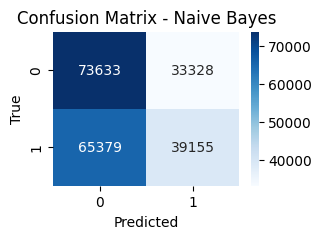



Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


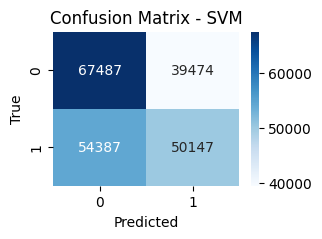



Evaluation for Model: Decision Tree
Accuracy: 0.5136528050308518
Precision: 0.5133883213175222
Recall: 0.5136528050308518
F1 Score: 0.5131399080137914


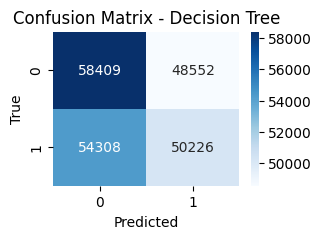



Evaluation for Model: Random Forest
Accuracy: 0.5305704626586917
Precision: 0.5304624634811943
Recall: 0.5305704626586917
F1 Score: 0.5304460738155468


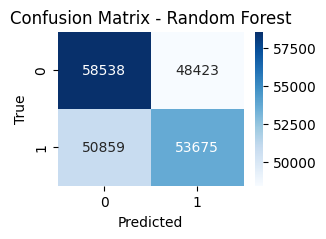


Epoch 2/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


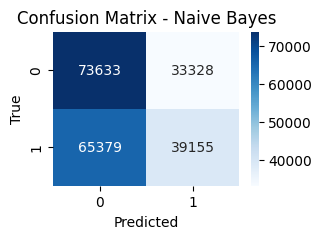



Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


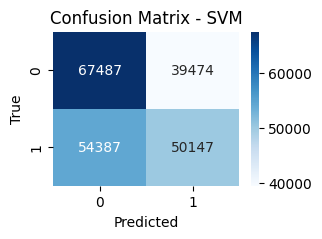



Evaluation for Model: Decision Tree
Accuracy: 0.5138135653325138
Precision: 0.5135080572728362
Recall: 0.5138135653325138
F1 Score: 0.5131201078033013


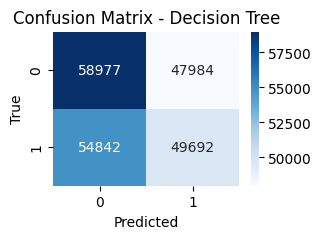



Evaluation for Model: Random Forest
Accuracy: 0.5305137237286933
Precision: 0.5304310392510387
Recall: 0.5305137237286933
F1 Score: 0.5304342115771249


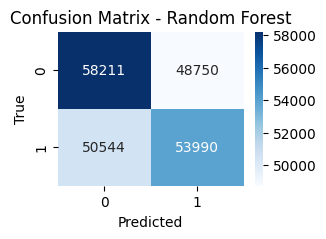


Epoch 3/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


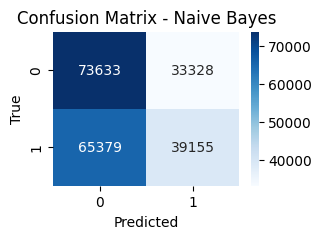



Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


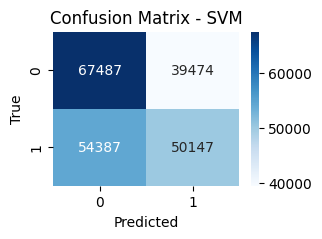



Evaluation for Model: Decision Tree
Accuracy: 0.5156008416274617
Precision: 0.5153313161322949
Recall: 0.5156008416274617
F1 Score: 0.515038860202833


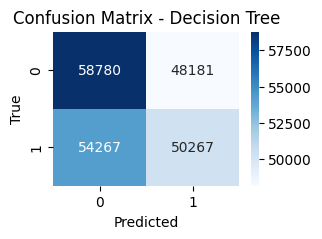



Evaluation for Model: Random Forest
Accuracy: 0.5326130641386321
Precision: 0.5325762815443834
Recall: 0.5326130641386321
F1 Score: 0.5325878320323195


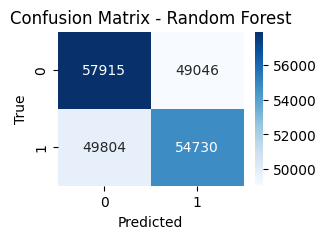


Epoch 4/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


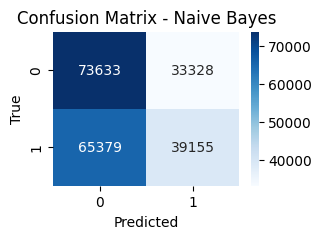

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


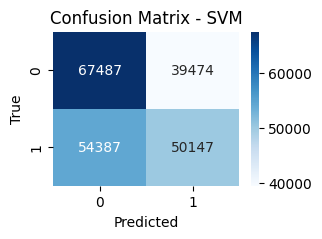

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5138088370883472
Precision: 0.5135626815179499
Recall: 0.5138088370883472
F1 Score: 0.5133621110675131


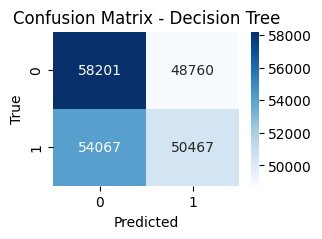



Evaluation for Model: Random Forest
Accuracy: 0.5319605664436512
Precision: 0.5319522125655586
Recall: 0.5319605664436512
F1 Score: 0.5319560618240011


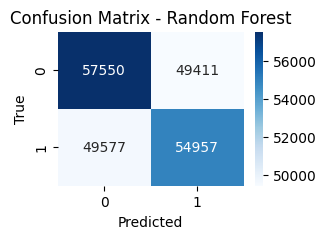


Epoch 5/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


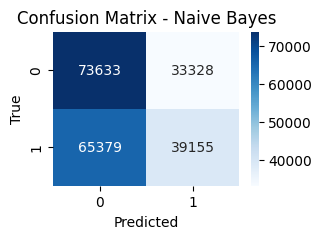

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


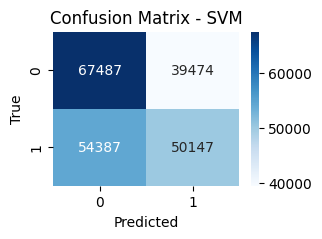

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5144566065391617
Precision: 0.5141446369818415
Recall: 0.5144566065391617
F1 Score: 0.5137150577705446


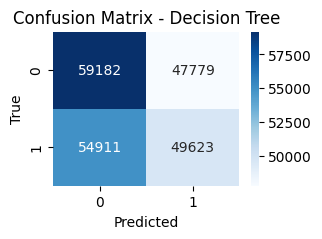



Evaluation for Model: Random Forest
Accuracy: 0.5327407267311284
Precision: 0.5327056781464549
Recall: 0.5327407267311284
F1 Score: 0.5327170116870349


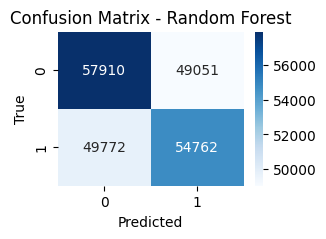


Epoch 6/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


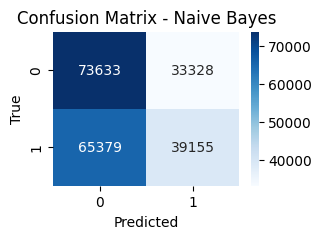

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


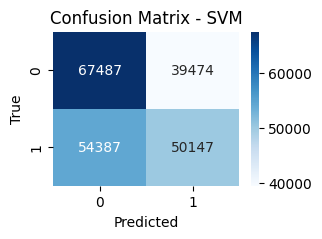

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5139837821225088
Precision: 0.513664955035175
Recall: 0.5139837821225088
F1 Score: 0.5132191381965201


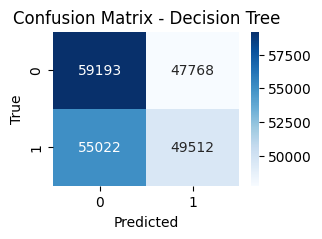

Early stopping for Decision Tree: No improvement for 3 consecutive epochs.


Evaluation for Model: Random Forest
Accuracy: 0.532925128253623
Precision: 0.5328315039898325
Recall: 0.532925128253623
F1 Score: 0.5328256746495614


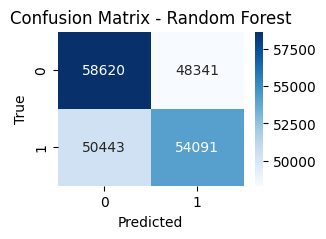


Epoch 7/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


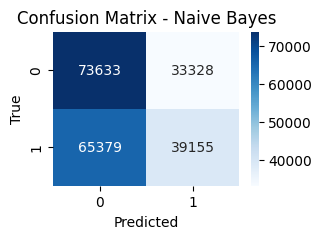

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


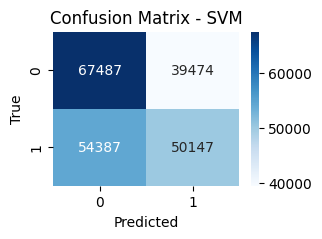

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5169436629707558
Precision: 0.516725031776904
Recall: 0.5169436629707558
F1 Score: 0.516564423783919


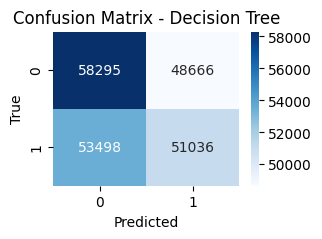



Evaluation for Model: Random Forest
Accuracy: 0.532353010709473
Precision: 0.5323597090303724
Recall: 0.532353010709473
F1 Score: 0.5323561556490017


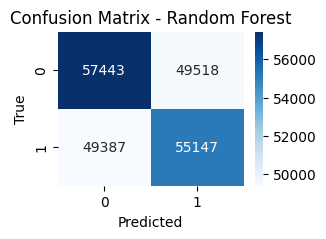


Epoch 8/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


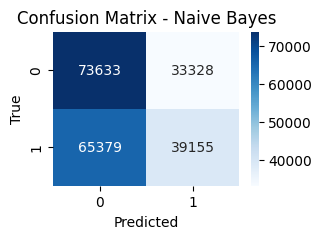

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


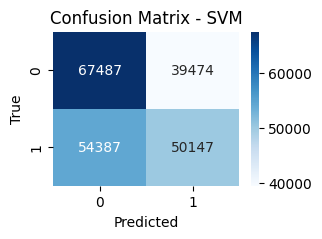

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5153313317099695
Precision: 0.5150831751378905
Recall: 0.5153313317099695
F1 Score: 0.5148607366347233


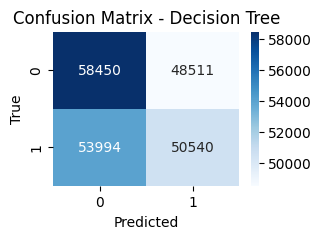



Evaluation for Model: Random Forest
Accuracy: 0.5329109435211234
Precision: 0.5329674669333109
Recall: 0.5329109435211234
F1 Score: 0.5329260456793671


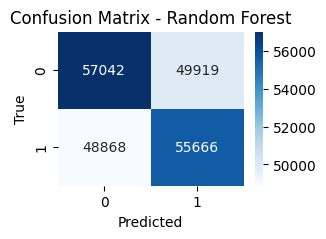


Epoch 9/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


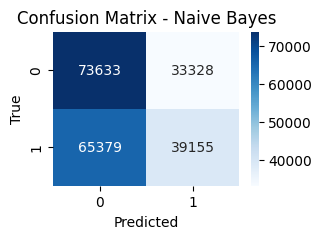

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


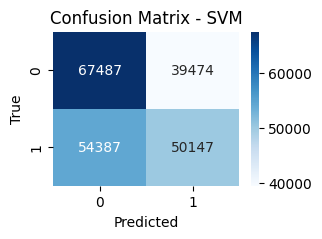

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5148395943166505
Precision: 0.5145472952913577
Recall: 0.5148395943166505
F1 Score: 0.5141872654926596


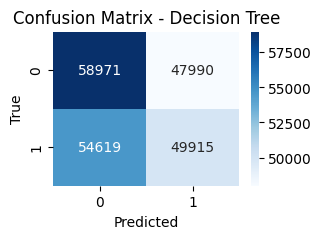



Evaluation for Model: Random Forest
Accuracy: 0.5326130641386321
Precision: 0.5325931415016968
Recall: 0.5326130641386321
F1 Score: 0.5326011787586044


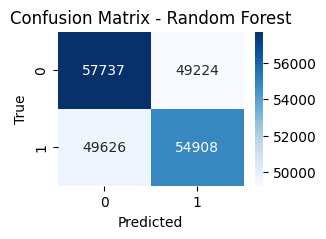

Early stopping for Random Forest: No improvement for 3 consecutive epochs.

Epoch 10/10


Evaluation for Model: Naive Bayes
Accuracy: 0.5332892030544457
Precision: 0.5348815688694393
Recall: 0.5332892030544457
F1 Score: 0.521444366202006


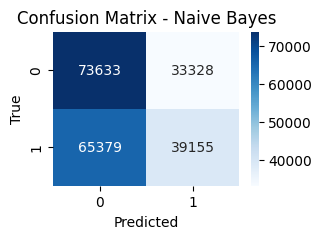

Early stopping for Naive Bayes: No improvement for 3 consecutive epochs.


Evaluation for Model: SVM
Accuracy: 0.5562022742854441
Precision: 0.5566113278140558
Recall: 0.5562022742854441
F1 Score: 0.5536192519941416


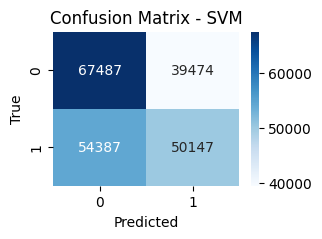

Early stopping for SVM: No improvement for 3 consecutive epochs.


Evaluation for Model: Decision Tree
Accuracy: 0.5159554599399513
Precision: 0.515672224911081
Recall: 0.5159554599399513
F1 Score: 0.5153235691674857


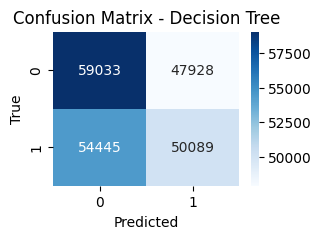

Early stopping for Decision Tree: No improvement for 3 consecutive epochs.


Evaluation for Model: Random Forest
Accuracy: 0.5328873023002908
Precision: 0.5328012174385905
Recall: 0.5328873023002908
F1 Score: 0.5328008908225537


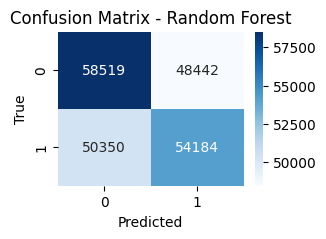

Early stopping for Random Forest: No improvement for 3 consecutive epochs.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize dictionaries to track the best accuracy and no improvement count for each model
best_accuracies = {model_name: -1 for model_name in models.keys()}
no_improvement_counts = {model_name: 0 for model_name in models.keys()}

# Train and evaluate models
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch + 1}/{n_epochs}")

    # Parallel training
    trained_models = Parallel(n_jobs=-1)(
        delayed(train_model)(model, X_batch, y_batch)
        for model, (X_batch, y_batch) in zip(models.values(), batch_generator(X_train, y_train, batch_size))
    )

    # Evaluate each model separately
    for model_name, model in zip(models.keys(), trained_models):
        print(f"\n\nEvaluation for Model: {model_name}")

        predictions = evaluate_model(model, X_test, y_test)
        if predictions is not None:
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
            recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
            f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
            confusion = confusion_matrix(y_test, predictions)

            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")

            # Confusion Matrix Plot
            plt.figure(figsize=(3, 2))
            sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
            plt.title(f'Confusion Matrix - {model_name}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

            # Update best accuracy and no improvement count for the model
            if accuracy > best_accuracies[model_name]:
                best_accuracies[model_name] = accuracy
                no_improvement_counts[model_name] = 0
            else:
                no_improvement_counts[model_name] += 1

            # Check for early stopping for each model
            if no_improvement_counts[model_name] >= early_stopping_rounds:
                print(f"Early stopping for {model_name}: No improvement for {early_stopping_rounds} consecutive epochs.")



Epoch 1/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


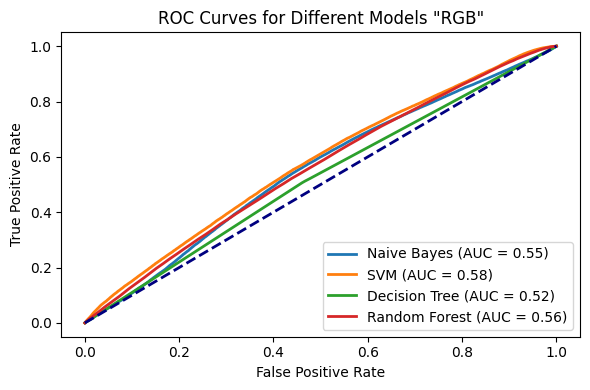


Epoch 2/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


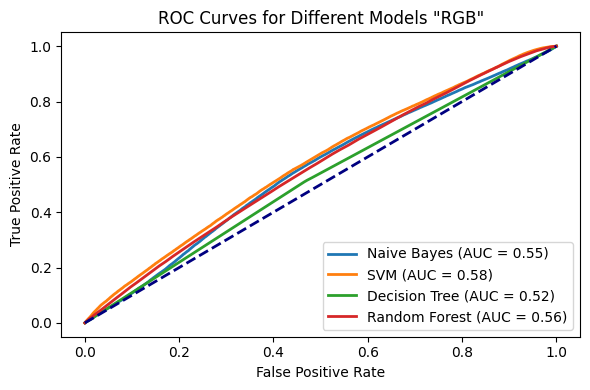


Epoch 3/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


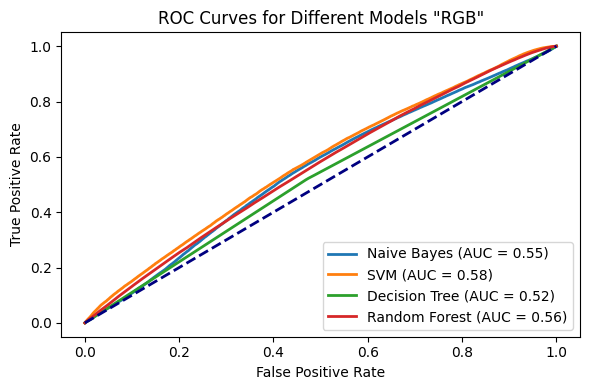


Epoch 4/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


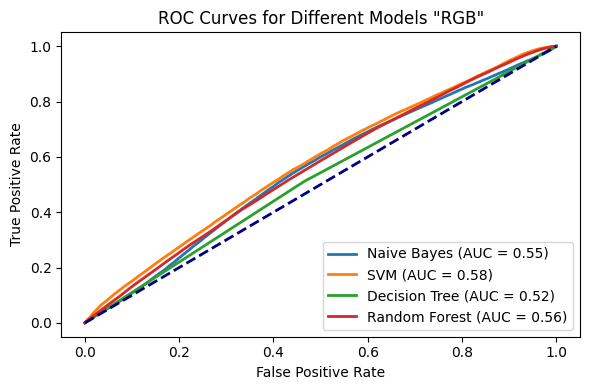


Epoch 5/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


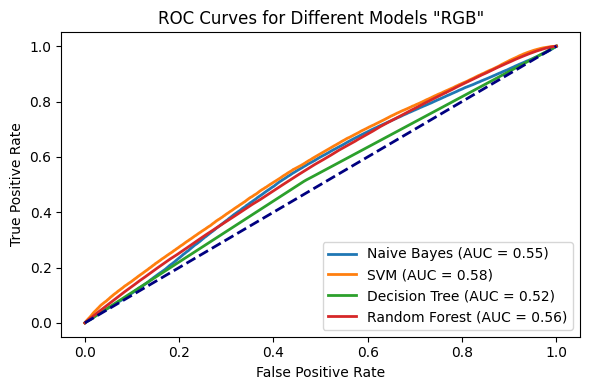


Epoch 6/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


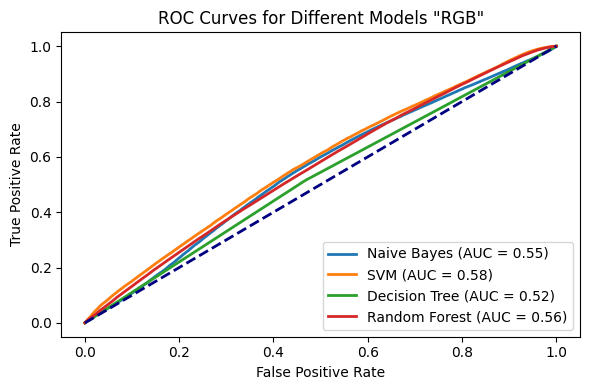


Epoch 7/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


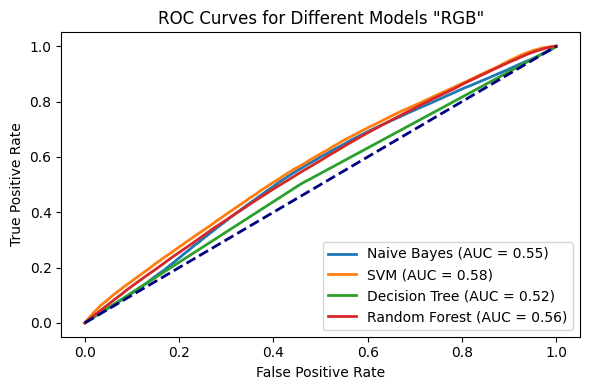


Epoch 8/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


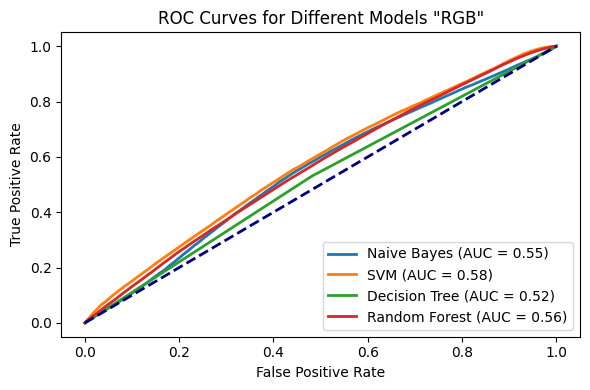


Epoch 9/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


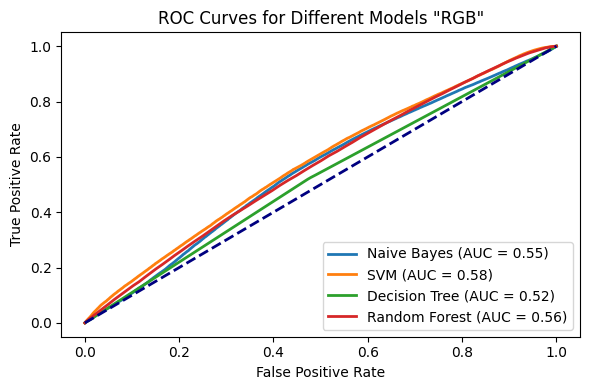


Epoch 10/10


Evaluation for Model: Naive Bayes


Evaluation for Model: SVM


Evaluation for Model: Decision Tree


Evaluation for Model: Random Forest


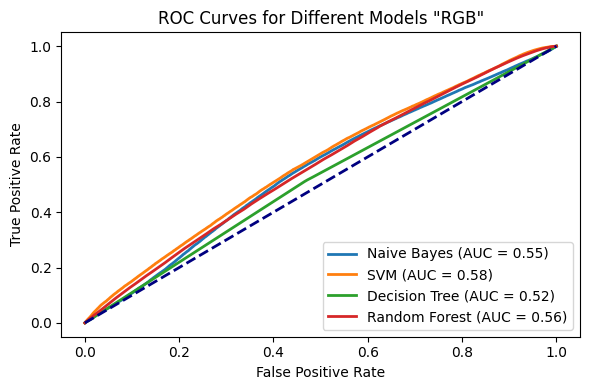

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Assuming X is your feature matrix and y is your target variable
# Adjust this based on your dataset
X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set hyperparameters
batch_size = 1000
n_epochs = 10

# Define classifiers
nb_model = GaussianNB()
svm_model = SVC(probability=True)
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

# Function to generate batches
def batch_generator(X, y, batch_size):
    n_samples = len(X)
    for i in range(0, n_samples, batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

# Function to train the model on a batch
def train_model(model, X_batch, y_batch):
    model.fit(X_batch, y_batch)
    return model

# Function to evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    try:
        if hasattr(model, "predict_proba"):
            predictions = model.predict_proba(X_test)[:, 1]
        else:
            predictions = model.decision_function(X_test)  # For SVM
        return predictions
    except NotFittedError:
        print(f"{type(model).__name__} model is not fitted. Call 'fit' with appropriate arguments before using this estimator.")
        return None

# Define classifiers
models = {'Naive Bayes': nb_model, 'SVM': svm_model, 'Decision Tree': dt_model, 'Random Forest': rf_model}

# Train and evaluate models
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch + 1}/{n_epochs}")

    # Train models
    trained_models = [train_model(model, X_batch, y_batch) for model, (X_batch, y_batch) in zip(models.values(), batch_generator(X_train, y_train, batch_size))]

    # Evaluate models
    plt.figure(figsize=(6, 4))
    for model_name, model in zip(models.keys(), trained_models):
        print(f"\n\nEvaluation for Model: {model_name}")

        predictions = evaluate_model(model, X_test, y_test)
        if predictions is not None:
            # Compute ROC curve and ROC area for each class
            fpr, tpr, _ = roc_curve(y_test, predictions)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Different Models "RGB"')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()